# 2d - Beispiel zum Assembling

Wir betrachten als Beispiel das zum 1d analoge Problem

$$-\Delta u = f(x)\quad\text{für}\ x\in\Omega = (0,1)^2$$

mit Dirichlet Randwerten und $f(x) \equiv 1$. Die schwache Gleichung ist gegeben durch

$$\int_\Omega \nabla u(x) \cdot \nabla v(x)\ dx = \int_\Omega f(x) v(x) dx\quad\forall v(x)\in H_0^1(\Omega).$$

## Definition des Gebiets und Meshes

Die Definition des Gebiets und Meshes wird nun etwas aufwändiger. Wir definieren zuerst die Knoten und danach darauf basierend die einzelnen Dreiecke. Das Mesh besteht daher aus einer Menge von Dreiecken, für welche $\Omega = \cup_i T_i$ gilt.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame

Die Punkte verteilen wir kartesisch auf dem Gebiet $\Omega = [0,1]^2$:

In [2]:
n = 3# Anzahl Intervalle in x/y Richtung
xi = np.linspace(0,1,n+1)
yi = np.linspace(0,1,n+1)
Xi,Yi = np.meshgrid(xi,yi)
pts = np.array([Xi.flatten(),Yi.flatten()]).T

Damit folgt

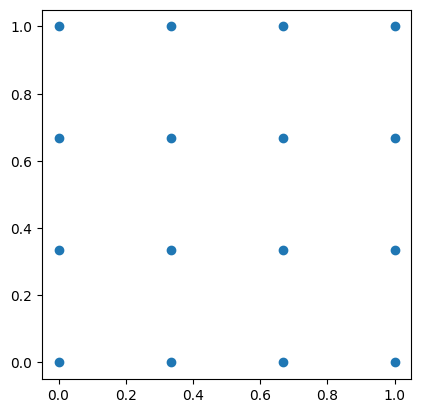

In [3]:
plt.plot(*pts.T,'o')
plt.gca().set_aspect(1)
plt.show()

Nun müssen die Dreiecke definiert werden. Es gilt

In [4]:
T = []
for i in range(n):
    for j in range(n):
        # in jedem Quadrat gilt
        # 1. Dreieck 1. Punkt,    2. Punkt,        3. Punkt (Nummer)
        T.append([   i*(n+1)+j,   i*(n+1)+j+1,     (i+1)*(n+1)+j])
        # 2. Dreieck 1. Punkt,    2. Punkt,        3. Punkt
        T.append([   i*(n+1)+j+1, (i+1)*(n+1)+j+1, (i+1)*(n+1)+j])
T = np.array(T)
T = np.reshape(T, (-1,3))
T

array([[ 0,  1,  4],
       [ 1,  5,  4],
       [ 1,  2,  5],
       [ 2,  6,  5],
       [ 2,  3,  6],
       [ 3,  7,  6],
       [ 4,  5,  8],
       [ 5,  9,  8],
       [ 5,  6,  9],
       [ 6, 10,  9],
       [ 6,  7, 10],
       [ 7, 11, 10],
       [ 8,  9, 12],
       [ 9, 13, 12],
       [ 9, 10, 13],
       [10, 14, 13],
       [10, 11, 14],
       [11, 15, 14]])

Damit folgt das Mesh

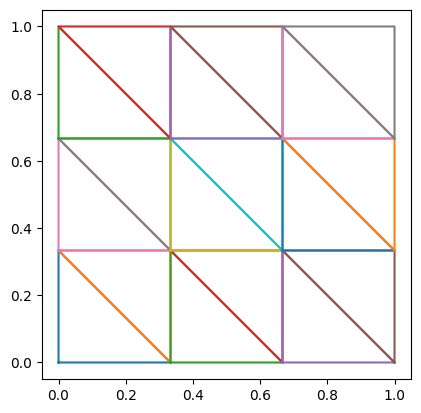

In [5]:
for t in T:
    plt.plot(*pts[t.tolist()+[t[0]]].T)
plt.gca().set_aspect(1)
plt.show()


## FE-Space mit Elemente 1. Ordnung

In [6]:
# Basisfunktionen auf dem Referenzelement
def myshape(t, j):
    xi, eta = t
    if j == 0:
        return 1-xi-eta
    elif j == 1:
        return xi
    else:
        return eta

# Gradienten der Basisfunktionen auf dem Referenzelement
def Dmyshape(t, j):
    if j == 0:
        return np.array([-1,-1])
    elif j == 1:
        return np.array([1,0])
    else:
        return np.array([0,1])

Pro Element gibt es drei Basisfunktionen. Wobei die Anzahlfreiheitsgrade aufgrund der Stetigkeitsbedingung durch die Anzahl Knoten gegeben ist. Damit folgt

In [7]:
len(pts)

16

Für die Integration über das Einheitsdreieck nutzen wir die numerische Integration aus `scipy`

In [8]:
from scipy.integrate import dblquad
# Integration über Einheitsdreieck
def quadT(f):
    return dblquad(f,0,1,0,lambda xi: 1-xi)[0]

Die Koordinaten Transformation ist gegeben durch

$$\begin{pmatrix}x\\y\end{pmatrix} = \vec{p}_1 + (\vec{p}_2-\vec{p}_1) \xi + (\vec{p}_3-\vec{p}_1) \eta = \vec{p}_1 + \underbrace{\big((\vec{p}_2-\vec{p}_1), (\vec{p}_3-\vec{p}_1)\big)}_{=:A_{t}}\cdot\begin{pmatrix}\xi\\\eta\end{pmatrix}$$

und entsprechend die inverse Transformation

$$\begin{pmatrix}\xi\\\eta\end{pmatrix} = A_t^{-1}\cdot\left(\begin{pmatrix}x\\y\end{pmatrix}-\vec{p}_1\right).$$


In [9]:
def sigma(p1,p2,p3):
    At = np.array([(p2-p1),(p3-p1)]).T
    return (lambda xi, eta: p1+At@(np.array([xi,eta])))

def invsigma(p1,p2,p3):
    At = np.array([(p2-p1),(p3-p1)]).T
    adjAt = np.array([[At[1,1],-At[0,1]],[-At[1,0],At[0,0]]])
    detAt = np.linalg.det(At)
    invAt = adjAt/detAt
    return (lambda x, y: invAt@(np.array([xi,eta])-p1))

In [10]:
def CnJ(p1,p2,p3):
    A = np.array([(p2-p1),(p3-p1)]).T
    adjA = np.array([[A[1,1],-A[0,1]],[-A[1,0],A[0,0]]])
    detA = np.linalg.det(A)
    invA = adjA/detA
    return invA@invA.T, detA

## Assembling der globalen Systemmatrix und -vektor

Wir berechnen daher das Gleichungssystem der diskreten schwachen Gleichung. Dazu benötigen wir die Funktion $f(x)$

In [11]:
def myfun(x,y):
    return 1
    #return np.sin(x*y) # x,y abhängiges Beispiel

In [12]:
def niceprint(A,t):
    df = DataFrame(A)
    highlights = np.zeros((N,N),dtype=bool)
    highlights[np.ix_(t,t)] = True
    cell_color = DataFrame(highlights)
    s = df.style.format('{:.2f}').set_table_styles([{'selector': '.True',  'props': [('background-color', 'yellow')]}], overwrite=True)
    s.set_td_classes(cell_color)
    display(s)
    return

In [13]:
N = pts.shape[0]
A = np.zeros((N,N),dtype=float)
f = np.zeros(N,dtype=float)

# Assembling
for k,t in enumerate(T):
    Ci, Ji = CnJ(*pts[t])
    si = sigma(*pts[t])
    
    # lokale Elementmatrix, Integration der shape und dshape function über das Einheitsdreieck
    Ai = np.array([[quadT(lambda xi, eta: Dmyshape([xi,eta],i)@Ci@Dmyshape([xi,eta],j)*Ji)
                   for j in range(3)] 
                  for i in range(3)])
    Mi = np.array([[quadT(lambda xi, eta: 10*myshape([xi,eta],i)*myshape([xi,eta],j)*Ji)
                   for j in range(3)] 
                  for i in range(3)])
    # Speichern in der globalen Matrix
    A[np.ix_(t,t)] += Ai#+Mi

    print('Element',k)
    print('lokale Elementmatrix')
    display(DataFrame(Ai).style.format('{:.2f}'))
    print('globale Matrix')
    niceprint(A,t)
    
    # lokale Linearform
    fi = np.array([quadT(lambda xi, eta: myfun(*si(xi,eta))*myshape([xi,eta],j)*Ji) for j in range(3)])
    f[t] += fi

Element 0
lokale Elementmatrix


globale Matrix


Element 1
lokale Elementmatrix


globale Matrix


Element 2
lokale Elementmatrix


globale Matrix


Element 3
lokale Elementmatrix


globale Matrix


Element 4
lokale Elementmatrix


globale Matrix


Element 5
lokale Elementmatrix


globale Matrix


Element 6
lokale Elementmatrix


globale Matrix


Element 7
lokale Elementmatrix


globale Matrix


Element 8
lokale Elementmatrix


globale Matrix


Element 9
lokale Elementmatrix


globale Matrix


Element 10
lokale Elementmatrix


globale Matrix


Element 11
lokale Elementmatrix


globale Matrix


Element 12
lokale Elementmatrix


globale Matrix


Element 13
lokale Elementmatrix


globale Matrix


Element 14
lokale Elementmatrix


globale Matrix


Element 15
lokale Elementmatrix


globale Matrix


Element 16
lokale Elementmatrix


globale Matrix


Element 17
lokale Elementmatrix


globale Matrix


## Lösen des Systems

Definieren der freien Freiheitsgrade, abhängig von den Randbedingungen

In [14]:
freedofs = []#np.array([4,5,7,8])
for k in range(1,n):
    freedofs += np.arange(k*(n+1)+1,(k+1)*(n+1)-1,dtype=int).tolist()
freedofs = np.array(freedofs)
print('freedofs=',freedofs)
sol = np.zeros(N)
sol[freedofs] = np.linalg.solve(A[np.ix_(freedofs,freedofs)],f[freedofs])
sol

freedofs= [ 5  6  9 10]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05555556, 0.05555556, 0.        , 0.        , 0.05555556,
       0.05555556, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

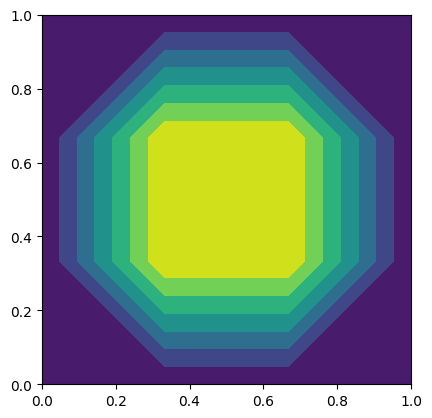

In [15]:
plt.contourf(pts[:,0].reshape((n+1,n+1)),pts[:,1].reshape((n+1,n+1)),sol.reshape((n+1,n+1)))
plt.gca().set_aspect(1)

## Äquivalente Lösung mit Hilfe von NGSolve

In [16]:
from ngsolve import *
from ngsolve.meshes import MakeStructured2DMesh
from ngsolve.webgui import Draw

Mesh erstellen

In [17]:
mesh = MakeStructured2DMesh(quads=False, nx = n, ny=n, mapping = lambda x,y: (x,y))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

Namen der Ränder:

In [18]:
mesh.GetBoundaries()

('bottom', 'right', 'top', 'left')

Definition des FE-Space, Bilinearform und Linearform sowie der Lösung

In [19]:
V = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = V.TnT()
gfu = GridFunction(V)

a = BilinearForm(V)
a += grad(u)*grad(v)*dx
a.Assemble()
b = LinearForm(V)
b += 1*v*dx(bonus_intorder=5)
b.Assemble()

gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*b.vec

Die Anzahl Freiheitsgrade ist gegeben durch

In [20]:
V.ndof

16

Unsere freien Freiheitsgrade sind gegeben durch:

In [21]:
freedofs

array([ 5,  6,  9, 10])

In NGSolve erhalten wir

In [22]:
print(V.FreeDofs())

0: 0000011001100000


Unser Lösungsvektor ist gegeben durch

In [23]:
print(sol)

[0.         0.         0.         0.         0.         0.05555556
 0.05555556 0.         0.         0.05555556 0.05555556 0.
 0.         0.         0.         0.        ]


Die Lösung von NGSolve ist identisch:

In [24]:
print(np.array(gfu.vec))

[0.         0.         0.         0.         0.         0.05555556
 0.05555556 0.         0.         0.05555556 0.05555556 0.
 0.         0.         0.         0.        ]


In [25]:
Draw(gfu,mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene